## 1D/2D/3D 卷积
```
卷积有一维卷积、二维卷积、三维卷积。一般情况下，卷积核在几个维度上滑动，就是几维卷积。比如在图片上的卷积就是二维卷积。

### 一维卷积
![AlexNet](https://image.zhangxiann.com/1d.gif "AlexNet")

### 二维卷积
![AlexNet](https://image.zhangxiann.com/2d-conv-2.gif "AlexNet")

### 三维卷积
![AlexNet](https://image.zhangxiann.com/3d.gif "AlexNet")

### 二维卷积：nn.Conv2d()
```python
nn.Conv2d(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=True, padding_mode='zeros')
```
```
    in_channels：输入通道数
    out_channels：输出通道数，等价于卷积核个数
    kernel_size：卷积核尺寸
    stride：步长
    padding：填充宽度，主要是为了调整输出的特征图大小，一般把 padding 设置合适的值后，保持输入和输出的图像尺寸不变。
    dilation：空洞卷积大小，默认为1，这时是标准卷积，常用于图像分割任务中，主要是为了提升感受野
    groups：分组卷积设置，主要是为了模型的轻量化，如在 ShuffleNet、MobileNet、SqueezeNet中用到
    bias：偏置

![size](image/1.png "size")

### 卷积网络示例
```
这里使用 inputchannel 为 3，output_channel 为 1 ，卷积核大小为 3*3 的卷积核nn.Conv2d(3, 1, 3)，使用`nn.init.xavier_normal()`方法初始化网络的权值。

In [69]:
# -*- coding: utf-8 -*-
"""
通用函数
"""


import torch
import random
import numpy as np
from PIL import Image
import torchvision.transforms as transforms


def transform_invert(img_, transform_train):
    """
    将data 进行反transfrom操作
    :param img_: tensor
    :param transform_train: torchvision.transforms
    :return: PIL image
    """
    if 'Normalize' in str(transform_train):
        norm_transform = list(filter(lambda x: isinstance(x, transforms.Normalize), transform_train.transforms))
        mean = torch.tensor(norm_transform[0].mean, dtype=img_.dtype, device=img_.device)
        std = torch.tensor(norm_transform[0].std, dtype=img_.dtype, device=img_.device)
        img_.mul_(std[:, None, None]).add_(mean[:, None, None])

    img_ = img_.transpose(0, 2).transpose(0, 1)  # C*H*W --> H*W*C
    if 'ToTensor' in str(transform_train):
        img_ = img_.detach().numpy() * 255

    if img_.shape[2] == 3:
        img_ = Image.fromarray(img_.astype('uint8')).convert('RGB')
    elif img_.shape[2] == 1:
        img_ = Image.fromarray(img_.astype('uint8').squeeze())
    else:
        raise Exception("Invalid img shape, expected 1 or 3 in axis 2, but got {}!".format(img_.shape[2]) )

    return img_


def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


image/lena.png
卷积前尺寸:torch.Size([1, 3, 512, 512])
卷积后尺寸:torch.Size([1, 1, 510, 510])


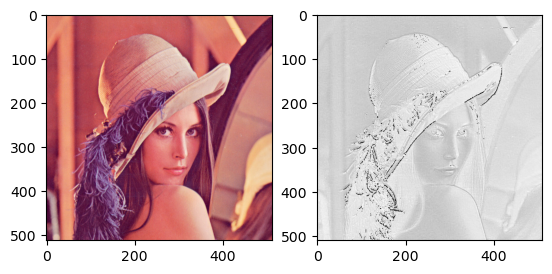

In [70]:
import os
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

set_seed(3)  # 设置随机种子

# ================================= load img ==================================
path_img = 'image/lena.png'
print(path_img)
img = Image.open(path_img).convert('RGB')  # 0~255

# convert to tensor
img_transform = transforms.Compose([transforms.ToTensor()])
img_tensor = img_transform(img)
# 添加 batch 维度
img_tensor.unsqueeze_(dim=0)    # C*H*W to B*C*H*W

# ================================= create convolution layer ==================================

# ================ 2d
flag = 1
# flag = 0
if flag:
    conv_layer = nn.Conv2d(3, 1, 3)   # input:(i, o, size) weights:(o, i , h, w)
    # 初始化卷积层权值
    nn.init.xavier_normal_(conv_layer.weight.data)
    # print(conv_layer.weight.data)
    # nn.init.xavier_uniform_(conv_layer.weight.data)
    # calculation
    img_conv = conv_layer(img_tensor)

# ================ transposed
# flag = 1
flag = 0
if flag:
    conv_layer = nn.ConvTranspose2d(3, 1, 3, stride=2)   # input:(input_channel, output_channel, size)
    # 初始化网络层的权值
    nn.init.xavier_normal_(conv_layer.weight.data)

    # calculation
    img_conv = conv_layer(img_tensor)

# ================================= visualization ==================================
print("卷积前尺寸:{}\n卷积后尺寸:{}".format(img_tensor.shape, img_conv.shape))

img_conv = transform_invert(img_conv[0, 0:1, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)

plt.subplot(122).imshow(img_conv, cmap='gray')
plt.subplot(121).imshow(img_raw)
plt.show()

### 转置卷积：nn.ConvTranspose()
```
转置卷积又称为反卷积 (Deconvolution) 和部分跨越卷积 (Fractionally strided Convolution)，用于对图像进行上采样。

```
原始的图片尺寸为 $4 \times 4$，卷积核大小为 $3 \times 3$，$padding =0$，$stride = 1$。由于卷积操作可以通过矩阵运算来解决，因此原始图片可以看作 $16 \times 1$ 的矩阵 $I{16 \times 1}$，卷积核可以看作 $4 \times 16$ 的矩阵$K{4 \times 16}$，那么输出是 $K{4 \times 16} \times I{16 \times 1} = O_{4 \times 1}$ 

正常卷积如下：
![img](https://image.zhangxiann.com/no_padding_no_strides.gif "img")

转置卷积如下：
![img](https://image.zhangxiann.com/no_padding_no_strides_transposed.gif "img")

 原始的图片尺寸为 $2 \times 2$，卷积核大小为 $3 \times 3$，$padding =0$，$stride = 1$。由于卷积操作可以通过矩阵运算来解决，因此原始图片可以看作 $4 \times 1$ 的矩阵 $I{4 \times 1}$，卷积核可以看作 $4 \times 16$ 的矩阵$K{16 \times 4}$，那么输出是 $K{16 \times 4} \times I{4 \times 1} = O_{16 \times 1}$ 。

 ```
 正常卷积核转置卷积矩阵的形状刚好是转置关系，因此称为转置卷积，但里面的权值不是一样的，卷积操作也是不可逆的。
 PyTorch 中的转置卷积函数如下：
 ```
 ```python
 nn.ConvTranspose2d(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, output_padding=0, groups=1, bias=True,
                 dilation=1, padding_mode='zeros')


### 转置卷积尺寸计算
#### 简化版转置卷积尺寸计算

这里不考虑空洞卷积，假设输入图片大小为 $ I \times I$，卷积核大小为 $k \times k$，stride 为 $s$，padding 的像素数为 $p$，图片经过卷积之后的尺寸 $ O $ 如下，刚好和普通卷积的计算是相反的：
$O = (I-1) \times s + k$

完整版简化版转置卷积尺寸计算:$O = (I-1) \times s - 2 \times p + d \times (k-1) + out_padding + 1$



image/lena.png
卷积前尺寸:torch.Size([1, 3, 512, 512])
卷积后尺寸:torch.Size([1, 3, 1025, 1025])


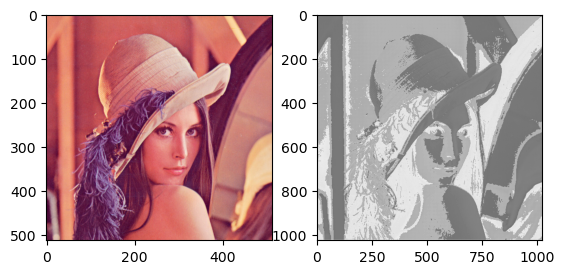

In [71]:
import os
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

set_seed(3)  # 设置随机种子

# ================================= load img ==================================
path_img = 'image/lena.png'
print(path_img)
img = Image.open(path_img).convert('RGB')  # 0~255

# convert to tensor
img_transform = transforms.Compose([transforms.ToTensor()])
img_tensor = img_transform(img)
# 添加 batch 维度
img_tensor.unsqueeze_(dim=0)    # C*H*W to B*C*H*W

# ================================= create convolution layer ==================================

# ================ 2d
# flag = 1
flag = 0
if flag:
    conv_layer = nn.Conv2d(3, 3, 3)   # input:(i, o, size) weights:(o, i , h, w)
    # 初始化卷积层权值
    nn.init.xavier_normal_(conv_layer.weight.data)
    # nn.init.xavier_uniform_(conv_layer.weight.data)

    # calculation
    img_conv = conv_layer(img_tensor)

# ================ transposed
flag = 1
# flag = 0
if flag:
    conv_layer = nn.ConvTranspose2d(3, 3, 3, stride=2)   # input:(input_channel, output_channel, size)
    # 初始化网络层的权值
    nn.init.xavier_normal_(conv_layer.weight.data)

    # calculation
    img_conv = conv_layer(img_tensor)

# ================================= visualization ==================================
print("卷积前尺寸:{}\n卷积后尺寸:{}".format(img_tensor.shape, img_conv.shape))
img_conv = transform_invert(img_conv[0, 0:1, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_conv,'gray')
plt.subplot(121).imshow(img_raw)
plt.show()